 <img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P4: Anticipez les besoins en consommation de bâtiments </span></font> </center>  

***

 <font size="4"> <span style="font-size: 1.5em" > **Partie 2: Machine Learning** </span> </font>  

**Contexte**  
La ville de Seattle veut atteindre son objectif de **ville neutre en émissions de carbone en 2050**. Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir.  
<img src="Seattle.png">
**Mission**  
* A partir des relevés déjà réalisés, **prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.   
* **Evaluer l’intérêt de l’"ENERGY STAR Score"** pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. 

**1. Réaliser une courte analyse exploratoire.**  
**2. Tester différents modèles de prédiction afin de répondre au mieux à la problématique.**

La première partie nous a permis de réaliser un nettoyage des données et une courte analyse exploratoire. Dans cette seconde partie, nous allons réaliser les diverses modélisations grâce à des approches linéaires, non-linéaires et ensemblistes afin de : 
* prédire la consommation d'énergie des bâtiments;
* prédire les émissions de CO2;
* évaluer l'intérêt de 'ENERGY STAR Score' pour la prédiction des émissions.

 <font size="4"> <span style="font-size: 1.5em" > **Partie 2.1: Prédiction de la consommation  'SiteEnergyUse(kBtu)'** </span> </font>  

Ce notebook sera dédié à la prédiction de la consommation 'SiteEnergyUse(kBtu)' sans prendre en compte la variable 'ENERGYSTARScore'.  

## Importation des librairies Python 

In [1]:
#------------------------------------------
# projet : Anticipez les besoins en consommation de bâtiments de la ville de Seattle
# Auteur : Rim BAHROUN
# Date: Décembre 2022
# OpenClassrooms
#-------------------------------------------
# importation des librairies Python pour DS
#-------------------------------------------
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import RFE

# Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.kernel_ridge import KernelRidge

import timeit

## Fonctions utiles pour la suite

In [2]:
# Définition de quelque fonction utile pour la suite
def linearRegressionSummary(model, column_names):
    '''Show a summary of the trained linear regression model'''

    # Plot the coeffients as bars
    fig = plt.figure(figsize=(12,len(column_names)/3))
    fig.suptitle('Linear Regression Coefficients', fontsize=16)
    rects = plt.barh(column_names, model.coef_,color="lightblue")

    # Annotate the bars with the coefficient values
    for rect in rects:
        width = round(rect.get_width(),4)
        plt.gca().annotate('  {}  '.format(width),
                    xy=(0, rect.get_y()),
                    xytext=(0,2),  
                    textcoords="offset points",  
                    ha='left' if width<0 else 'right', va='bottom')        
    plt.show()
    
def score(model, X, y):
    """Get the model prediction scores using the provided input and target features"""
    
    predictions = model.predict(X)
    print("    R2", metrics.r2_score(y, predictions))     
    
def correlatedFeatures(dataset, threshold):
    """Function to list features that are correlated
       Adds the first of the correlated pair only (not both)"""
    
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns    


def kFoldCV(X, y, silent=False):
    """Evaluate linear regression with k-fold cross validation"""
    
    model = LinearRegression()
    
    # Create folds
    seed = 0
    kfold = KFold(n_splits=10, shuffle=False)#, , random_state=seed)#5 
    
    # Perform kfold cross validation
    results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    
    # Show results
    if not silent:
        print(type(model).__name__)
        print("kFoldCV:")
        print("    Fold R2 scores:", results)
        print("    Mean R2 score:", results.mean())
        print("    Std R2 score:", results.std())
    
    # Build a model using all the data and return it
    model.fit(X, y)

    return model

In [3]:
#pour afficher 165 colonnes ou lignes minimum
pd.set_option('display.max_column', 165) 
pd.set_option('display.max_row', 165) 

## Importation des données 

In [4]:
# importation des données
data_Seattle = pd.read_csv('data_cleaned.csv')

In [5]:
data = data_Seattle.copy()
data.shape

(1513, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PrimaryPropertyType  1513 non-null   object 
 1   CouncilDistrictCode  1513 non-null   object 
 2   NumberofFloors       1513 non-null   int64  
 3   PropertyGFATotal     1513 non-null   int64  
 4   ENERGYSTARScore      983 non-null    float64
 5   SiteEnergyUse(kBtu)  1513 non-null   float64
 6   TotalGHGEmissions    1513 non-null   float64
 7   Agebuilding          1513 non-null   int64  
 8   NaturalGas_use       1513 non-null   int64  
 9   Electricity_use      1513 non-null   int64  
 10  Steam_use            1513 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 130.1+ KB


In [7]:
data.drop(columns=['CouncilDistrictCode'], inplace=True)

Les résultats sans la variable 'CouncilDistrictCode' sont meilleurs. J'ai décidé de la supprimer pour la suite.  

# Preprocessing

## Encodage

Pour les données catégorielles, nous allons devoir encoder les valeurs. J'utiliserai dans la suite 'get_dummies' qui convertie les fariables catégorielles en variables numériques binaires 0/1. 

In [8]:
data['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    285
Other                          236
Warehouse                      185
Large Office                   168
Mixed Use Property             109
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
K-12 School                     38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

In [9]:
categoricals = ['PrimaryPropertyType']#
data = pd.get_dummies(data, columns=categoricals, prefix=[''])
data.head()

,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Agebuilding,NaturalGas_use,Electricity_use,Steam_use,_Distribution Center,_Hospital,_Hotel,_K-12 School,_Laboratory,_Large Office,_Low-Rise Multifamily,_Medical Office,_Mixed Use Property,_Other,_Refrigerated Warehouse,_Residence Hall,_Restaurant,_Retail Store,_Self-Storage Facility,_Senior Care Community,_Small- and Mid-Sized Office,_Supermarket / Grocery Store,_University,_Warehouse,_Worship Facility
0,12,88434,60.0,7226362.5,249.98,89,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11,103566,61.0,8387933.0,295.86,20,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,41,956110,43.0,72587024.0,2089.28,47,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10,61320,56.0,6794584.0,286.43,90,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,175580,75.0,14172606.0,505.01,36,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
data.shape

(1513, 30)

## Split into X and y

La variable 'SiteEnergyUse(kBtu)' passera en **y** comme variable target pour ce notebook.  
'ENERGYSTARScore' est insuffisement complété. Nous allons l'écarter du dataset pour la prédiction de l'énergie. Nous supprimerons égalent la variable 'TotalGHGEmissions' qui est notre deuxième target. Le reste des variables formera notre matrice de données **X** de dimension 1513 lignes et 27 colonnes. 

In [11]:
y = data['SiteEnergyUse(kBtu)']
X_ = data.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'ENERGYSTARScore'], axis=1)

In [12]:
X_

,NumberofFloors,PropertyGFATotal,Agebuilding,NaturalGas_use,Electricity_use,Steam_use,_Distribution Center,_Hospital,_Hotel,_K-12 School,_Laboratory,_Large Office,_Low-Rise Multifamily,_Medical Office,_Mixed Use Property,_Other,_Refrigerated Warehouse,_Residence Hall,_Restaurant,_Retail Store,_Self-Storage Facility,_Senior Care Community,_Small- and Mid-Sized Office,_Supermarket / Grocery Store,_University,_Warehouse,_Worship Facility
0,12,88434,89,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11,103566,20,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,41,956110,47,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10,61320,90,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,175580,36,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,1,18261,34,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1509,1,16000,12,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1510,1,13157,42,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1511,1,14101,27,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Train and test sets 

Afin de tester notre meilleur modèle sur des données "inconnues", nous allons mettre de côté une partie des données initiales qui ne seront pas inclusent dans les modèles intermédiaires. Nous allons donc spliter nos données pour obtenir un jeu d'entrainement et un jeu de test (30% des données).

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=0, test_size=0.3)

In [14]:
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ' , X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (1059, 27)
y_train.shape =  (1059,)
X_test.shape =  (454, 27)
y_test.shape =  (454,)


**Entrainement**: 1059 lignes,  
**Test**: 454 lignes.

In [86]:
X_train.head(2)

,NumberofFloors,PropertyGFATotal,Agebuilding,NaturalGas_use,Electricity_use,Steam_use,_Distribution Center,_Hospital,_Hotel,_K-12 School,_Laboratory,_Large Office,_Low-Rise Multifamily,_Medical Office,_Mixed Use Property,_Other,_Refrigerated Warehouse,_Residence Hall,_Restaurant,_Retail Store,_Self-Storage Facility,_Senior Care Community,_Small- and Mid-Sized Office,_Supermarket / Grocery Store,_University,_Warehouse,_Worship Facility
0,-0.524953,-0.006726,-0.958441,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.042658,-0.174495,-1.292000,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Standardisation

Les données numériques ('NumberofFloors', 'PropertyGFATotal', 'Agebuilding') doivent être standardisées pour entrer dans nos modèles de prédiction. Nous réaliserons un centrage-réduction via la méthode StandardScaler de Scikit-Learn.

In [16]:
# Rescale the input features
columns_to_scale = X_.columns[:3]
coumns_not_to_scale = X_.columns[3:]

scaler = StandardScaler()

X_train_scaled_ = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled_ = scaler.transform(X_test[columns_to_scale])

X_train_scaled = pd.DataFrame(X_train_scaled_, columns=columns_to_scale)
X_test_scaled = pd.DataFrame(X_test_scaled_, columns=columns_to_scale)

In [17]:
X_train_not_to_scale = X_train[coumns_not_to_scale]
X_test_not_to_scale = X_test[coumns_not_to_scale]

In [18]:
X_train_not_to_scale.reset_index(inplace=True, drop=True)
X_test_not_to_scale.reset_index(inplace=True, drop=True)

In [19]:
X_train = pd.merge(X_train_scaled, X_train_not_to_scale, left_index =True, right_index = True)
X_train.shape

(1059, 27)

In [20]:
X_test = pd.merge(X_test_scaled, X_test_not_to_scale, left_index =True, right_index = True)
X_test.shape

(454, 27)

In [21]:
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [22]:
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ' , X_test.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (1059, 27)
y_train.shape =  (1059,)
X_test.shape =  (454, 27)
y_test.shape =  (454,)


In [87]:
X_train.head(3)

,NumberofFloors,PropertyGFATotal,Agebuilding,NaturalGas_use,Electricity_use,Steam_use,_Distribution Center,_Hospital,_Hotel,_K-12 School,_Laboratory,_Large Office,_Low-Rise Multifamily,_Medical Office,_Mixed Use Property,_Other,_Refrigerated Warehouse,_Residence Hall,_Restaurant,_Retail Store,_Self-Storage Facility,_Senior Care Community,_Small- and Mid-Sized Office,_Supermarket / Grocery Store,_University,_Warehouse,_Worship Facility
0,-0.524953,-0.006726,-0.958441,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.042658,-0.174495,-1.292000,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.524953,0.076455,-1.201029,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# Modélisation

Nous allons calculer 3 métriques pour évaluer nos modèles :

* MAE : Mean Absolute Error.   
La MAE, ou erreur absolue moyenne, est la moyenne des valeurs absolues des erreurs.
\begin{equation*}
MAE =  \frac{1}{n} \sum_{i=1}^n |y_i – \hat{y}_i|
\end{equation*}
La MAE est dans la même unité que la variable à prédire. Par conséquent, elle est facile à interpréter.
Cette métrique quantifie l’erreur réalisée par le modèle. Plus elle est élevée, moins le modèle est performant.  
La MAE pénalise autant les grandes erreurs que les petites erreurs, contrairement à la RMSE.
Du fait de l’utilisation d’une valeur absolue dans la somme, une erreur 3 fois plus grande aura 3 fois plus d’impact sur l’erreur. Cette métrique est sensible aux outliers. L’observation d’une valeur aberrante pénalise le modèle, mais moins que pour la RMSE.  

* RMSE : Root Mean Squared Error.  
La RMSE est la racine de l’erreur quadratique moyenne.
\begin{equation*} RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i – \hat{y}_i)^2} \end{equation*}

La RMSE pénalise plus fortement les grandes erreurs que les petites. Etant donné le carré dans la somme, une erreur 3 fois plus grande aura 9 fois plus d’impact sur la moyenne. Par conséquent elle est très sensible aux outliers.
Les outliers sont des points pour lesquels la valeur réelle est aberrante. La prédiction sera donc souvent très éloignée de cette valeur aberrante, ce qui accroît fortement la contribution des individus outliers dans cette métrique.

* R² : Coeficient de détermination est le carré du coefficient de corrélation linéaire.  
\begin{equation*} R^2 = 1 - \frac{\sum_{i=1}^{n}{(y_i-\hat{y}_i)^2}}{\sum_{i=1}^{n}{(y_i-\bar{y})^2}} \end{equation*}

Plus le $R^2$ est proche de 1 meilleur est notre prédiction. Le coefficient de détermination nous indique à quel point les valeurs prédites sont corrélées aux vraies valeurs. 

Avec 
* $y_i$: valeure réelle  
* $\hat{y}_i$: valeure prédite
* $\bar{y}$: valeure moyenne


## Baseline: DummyRegressor

A présent, nous allons créer un modèle baseline pour évaluer les performances de nos futurs modèles et vérifier qu'ils améliorent les prédictions. Pour cette baseline, nous utiliserons une prédiction par la moyenne avec un **DummyRegressor**.

In [23]:
# Build and evaluate a dummy regression model 

# Create model
name_reg = 'DummyRegressor'
model = DummyRegressor()

# Fit model
model.fit(X_train, y_train)

# Prediction
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Evaluate
df_Result = pd.DataFrame({})
df_Result.loc[name_reg,'R2_train'] = round(model.score(X_train, y_train),2) # coéfficient de détermination
df_Result.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
df_Result.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
df_Result.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
df_Result.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
df_Result.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)

df_Result

,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test
DummyRegressor,0.0,-0.0,2.037876e+07,1.442503e+07,8.335603e+06,7.735421e+06


## Régression linéaire simple

En premier lieu, nous s'intéresserons à l'étude d'un modèle de régression linéaire simple.  

### Prédiction sans cross-validation

Train set:
    R2 0.6425287538635458
Test set:
    R2 0.6500376484193094


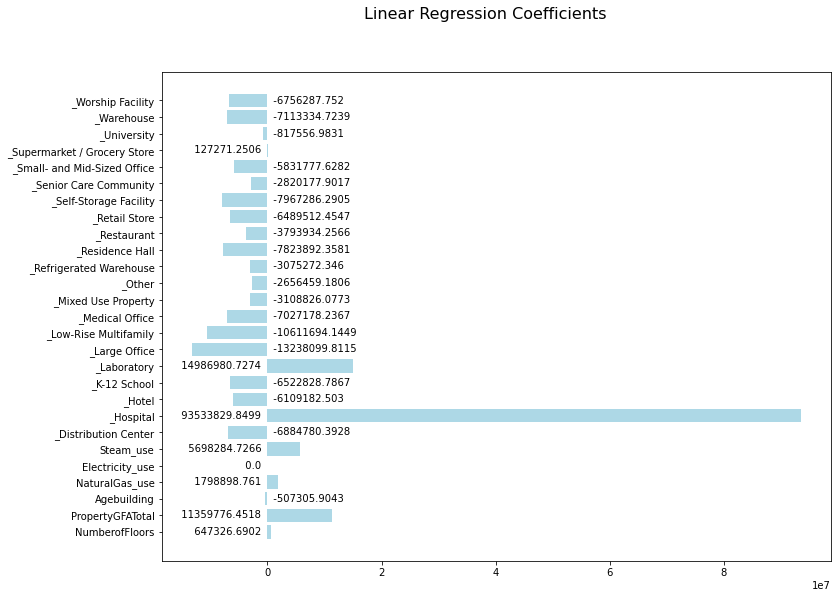

In [24]:
# Build and evaluate a linear regression model 

# Create model
model = LinearRegression()

# Fit model
model.fit(X_train, y_train)
print("Train set:")
score(model, X_train, y_train)

# Evaluate
print("Test set:")
score(model, X_test, y_test)

# Summary
linearRegressionSummary(model, X_train.columns)#.regressor_

Le modèle linéaire simple donne de bonne résultat sur le train et le test set.   
L'étude de l'importance des variables dans la prédiction, montre que les variables 'Hospital', 'Laboratory' et surface du bâtiment 'PropertyGFATotal' sont les plus importantes pour ce modèle. Ce résultat est attendu vu que la consommation dépend de la surface et elle est beaucoup plus importante pour les Hôpitaux et les laboratoires. Dans la suite, on étudera la stabilité de notre modèle par rapport au choix de Train/Test dans le jeu de données. 

### Prédiction avec cross-validation 

In [25]:
# Evaluate the linear regression model using 10-fold cross validation
model = kFoldCV(X_train, y_train)

# I will evaluate using the train set
print("Train set")
score(model, X_train, y_train)

# I will evaluate using the test set
print("Test set")
score(model, X_test, y_test)

LinearRegression
kFoldCV:
    Fold R2 scores: [ 0.10139998  0.43518357  0.56101711  0.56491769  0.65029713  0.77297321
 -0.42303364  0.56985363  0.81235374  0.81735674]
    Mean R2 score: 0.48623191635673646
    Std R2 score: 0.3635078165366946
Train set
    R2 0.6425287538635458
Test set
    R2 0.6500376484193094


Le modèle n'est pas stable par rapport au découpage train/test. Ce là est dû à la taille de notre jeu de données et la présence de quelque bâtiments (hôpitaux et laboratoires) qui consomment beaucoup d'énergie par rapport au reste des bâtiements. Pour valider cette justification, nous testerons le K-Fold avec un jeu de données sans les hôpitaux et les laboratoires.  

In [26]:
Xy_train = X_train.copy() 
Xy_train['Y'] = y_train
Xy1_train = Xy_train.loc[(Xy_train['_Hospital']==0)&(Xy_train['_Laboratory']==0),:]
Xy1_train.reset_index(inplace=True, drop=True)
X1_train = Xy1_train.iloc[:,:-1] 
y1_train = Xy1_train.iloc[:,-1:] 

Xy_test = X_test.copy() 
Xy_test['Y'] = y_test
Xy1_test = Xy_test.loc[(Xy_test['_Hospital']==0)&(Xy_test['_Laboratory']==0),:]
Xy1_test.reset_index(inplace=True, drop=True)
X1_test = Xy1_test.iloc[:,:-1] 
y1_test = Xy1_test.iloc[:,-1:] 

In [27]:
print('X1_train.shape = ', X1_train.shape)
print('y1_train.shape = ', y1_train.shape)
print('X1_test.shape = ' , X1_test.shape)
print('y1_test.shape = ',y1_test.shape)

X1_train.shape =  (1045, 27)
y1_train.shape =  (1045, 1)
X1_test.shape =  (448, 27)
y1_test.shape =  (448, 1)


In [28]:
# Evaluate the linear regression model using 10-fold cross validation
model = kFoldCV(X1_train, y1_train)

# # I will evaluate using the train set
# print("Train set")
# score(model, X1_train, y1_train)

# # I will evaluate using the test set
# print("Test set")
# score(model, X1_test, y1_test)

LinearRegression
kFoldCV:
    Fold R2 scores: [0.15951526 0.59514429 0.65099365 0.61814863 0.65057703 0.67629769
 0.38521744 0.57431303 0.7668733  0.6579127 ]
    Mean R2 score: 0.57349930062295
    Std R2 score: 0.16623133284641606


La stabilité du modèle vis à vis au découpage Train/test est meilleure. Comme nous souhaitons prédire la consommation indépendamment du type d'utilisation. On gardera dans la suite tous les bâtiments quelque soit leur consommation. 

### Sélection de variables par un  RFE

RFE: Recursive Feature Elimination. Sélectionner automatiquement les variables pertinentes pour une régression linéaire. Le but de l'élimination récursive des caractéristiques (RFE) est de sélectionner les caractéristiques en considérant de manière récursive des ensembles de plus en plus petits de caractéristiques. Tout d'abord, l'estimateur est entraîné sur l'ensemble initial de caractéristiques et l'importance de chaque caractéristique est obtenue par le biais d'un attribut spécifique ou d'un appel. Ensuite, les caractéristiques les moins importantes sont élaguées de l'ensemble actuel de caractéristiques. Cette procédure est répétée de manière récursive sur l'ensemble élagué jusqu'à ce que le nombre souhaité de caractéristiques à sélectionner soit finalement atteint.

In [29]:
# Build models using from 1 to n-1 features
for i in range(1, X_train.shape[1]+1):
    print("\nRFE ", i, end="\t")
    # Create a model
    model = LinearRegression()

    # Select the best features according to RFE
    rfe = RFE(model, n_features_to_select = i)
    rfe.fit(X_train, y_train)

    # Transform (remove features not selected)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Evaluate using k-fold cross-validation
    model = kFoldCV(X_train_rfe, y_train, silent=True)
    predictions = model.predict(X_test_rfe)
    print("R2", metrics.r2_score(y_test, predictions)) 


RFE  1	R2 0.32319460729935545

RFE  2	R2 0.3158666496107053

RFE  3	R2 0.6807753068920561

RFE  4	R2 0.6463140435750182

RFE  5	R2 0.6535893996628563

RFE  6	R2 0.6535305878495979

RFE  7	R2 0.6540747420473982

RFE  8	R2 0.6535316117181507

RFE  9	R2 0.6582626135392782

RFE  10	R2 0.6528941496417378

RFE  11	R2 0.6543442742544359

RFE  12	R2 0.6555351496185362

RFE  13	R2 0.6529988776053424

RFE  14	R2 0.6531177021315817

RFE  15	R2 0.6561818677775773

RFE  16	R2 0.6514313378922477

RFE  17	R2 0.6515630245116273

RFE  18	R2 0.651260808327263

RFE  19	R2 0.6521706631393196

RFE  20	R2 0.655075146241499

RFE  21	R2 0.6543014489332928

RFE  22	R2 0.6535109487592043

RFE  23	R2 0.6541294548882819

RFE  24	R2 0.6514213380269855

RFE  25	R2 0.6500376484193093

RFE  26	R2 0.6500376484193096

RFE  27	R2 0.6500376484193094


Le meilleur score $R^2$ est obtenu avec 3 variables. Gardons que ces 3 variables et évaluons notre modèle. 

In [30]:
# Create a model
model = LinearRegression()

# Select the best features according to RFE
rfe = RFE(model, n_features_to_select = 3)
rfe.fit(X_train, y_train)

selected_features = list(X_train.columns[rfe.support_])
print("Feature selection", rfe.support_)
print("Feature ranking", rfe.ranking_)
print("Selected features:", selected_features)
print("Removed features:", list(X_train.columns[~rfe.support_]))

Feature selection [False  True False False False False False  True False False  True False
 False False False False False False False False False False False False
 False False False]
Feature ranking [22  1 23 20 25  3  9  1 14 12  1  2  4  8 17 18 15  6 16 11  5 19 13 24
 21  7 10]
Selected features: ['PropertyGFATotal', '_Hospital', '_Laboratory']
Removed features: ['NumberofFloors', 'Agebuilding', 'NaturalGas_use', 'Electricity_use', 'Steam_use', '_Distribution Center', '_Hotel', '_K-12 School', '_Large Office', '_Low-Rise Multifamily', '_Medical Office', '_Mixed Use Property', '_Other', '_Refrigerated Warehouse', '_Residence Hall', '_Restaurant', '_Retail Store', '_Self-Storage Facility', '_Senior Care Community', '_Small- and Mid-Sized Office', '_Supermarket / Grocery Store', '_University', '_Warehouse', '_Worship Facility']


Le meilleur score $R^2$ est obtenu avec un modèle utilisant uniquement 3 variables: 'Hospital', 'Laboratory' et surface du bâtiment 'PropertyGFATotal'. Ce résultat confirme l'analyse d'importance des variables déjà effectué.

In [31]:
# Transform (remove features not selected)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

Nous effectuons une prédiction en utilisant uniquement les 3 variables sélectionnées par la RFE et nous regarderons les performances de notre modèle. 

In [32]:
selected_features

['PropertyGFATotal', '_Hospital', '_Laboratory']

In [33]:
# Build and evaluate a linear regression model with the reduced feature set
model = kFoldCV(X_train_rfe, y_train)

print("Train set:")
score(model, X_train_rfe, y_train)

print("Test set:")
score(model, X_test_rfe, y_test)

LinearRegression
kFoldCV:
    Fold R2 scores: [ 0.11947095  0.50361464  0.60220965  0.51797271  0.69354344  0.76382455
 -0.58274073  0.5086706   0.81365846  0.80745599]
    Mean R2 score: 0.4747680271962455
    Std R2 score: 0.4026902866925111
Train set:
    R2 0.6157986038337356
Test set:
    R2 0.6807753068920561


## Modélisation avec optimisation des hyperparamètres

Pour chaque modèle, nous calculons, la MAE, la RMSE et le R². 
Nous prenons en considération le temps de calcul pour chaque algorithme de prédiction. 

In [34]:
# Dictionnaire de regresseurs
regressors_grid = {
    # modèles linéaires:    
               'Dummy': DummyRegressor(), #mean
               'Linear': LinearRegression(),
               'Ridge' : Ridge(),
               'Lasso' : Lasso(),
               'Elastic_Net' : ElasticNet(),
               'Linear_SVR' : LinearSVR(),
    # modèles non linéaires: 
               'KRR': KernelRidge(),
                'KNR': KNeighborsRegressor(),
    # modèles ensemblistes:          
               'Random Forest': RandomForestRegressor(),
               'Extra Tree': ExtraTreesRegressor(),
               'Gradient Boosting': GradientBoostingRegressor(),

            }
grid_params = { 'Dummy'        : {},
                'Linear'       : {},
                'Ridge'        : {'alpha':np.logspace(-2, 2, 10)},#Ridge__alpha
                'Lasso'        : {'alpha':np.logspace(2, 8, 10)},
                'Elastic_Net'  : {'alpha': np.logspace(-10, 0, 10)},
                'Linear_SVR'   : {'epsilon' : np.logspace(-5, 5, 10), 
                                 'C' : np.logspace(0, 10, 10)},
                 'KRR'          : {'gamma' : np.logspace(-20, 0, 10) },
                 'KNR'          : {'n_neighbors': np.arange(2, 10, 2)},
                 'Random Forest': {'max_depth': [5, 10, 20, 30],
                                  'n_estimators': [100, 150, 200]},
                 'Extra Tree'    : {'n_estimators': [50,100,120],
                                  'criterion': ['mse', 'mae'],
                                   'max_depth': [4,8,10,12]},# 
               'Gradient Boosting': {'n_estimators':[10,50,100]},
              } 


### Avec toutes les variables 

Dummy {}
Linear {}
Ridge {'alpha': 1.6681005372000592}
Lasso {'alpha': 215443.46900318822}
Elastic_Net {'alpha': 0.005994842503189421}
Linear_SVR {'C': 59948425.03189421, 'epsilon': 46.41588833612782}
KRR {'gamma': 1e-20}
KNR {'n_neighbors': 8}
Random Forest {'max_depth': 20, 'n_estimators': 100}
Extra Tree {'criterion': 'mae', 'max_depth': 8, 'n_estimators': 100}
Gradient Boosting {'n_estimators': 50}


,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s)
Dummy,0.00,-0.00,2.037876e+07,1.442503e+07,8.335603e+06,7.735421e+06,0.02
Linear,0.64,0.65,1.218423e+07,8.531674e+06,4.306122e+06,4.155076e+06,0.05
Ridge,0.64,0.62,1.227807e+07,8.903831e+06,4.374486e+06,4.206827e+06,0.43
Lasso,0.61,0.61,1.269657e+07,9.058292e+06,4.422532e+06,4.153539e+06,0.68
Elastic_Net,0.63,0.59,1.242873e+07,9.220914e+06,4.430046e+06,4.251423e+06,1.77
Linear_SVR,0.55,0.67,1.373892e+07,8.281911e+06,3.572749e+06,3.418771e+06,11.56
KRR,0.64,0.63,1.222452e+07,8.811158e+06,4.352169e+06,4.236737e+06,2.28
KNR,0.56,0.36,1.359422e+07,1.157964e+07,3.825163e+06,4.197080e+06,0.23
Random Forest,0.96,0.71,3.823459e+06,7.756818e+06,1.408085e+06,3.541702e+06,47.87
Extra Tree,0.94,0.74,4.809168e+06,7.342922e+06,2.016432e+06,3.338891e+06,477.13


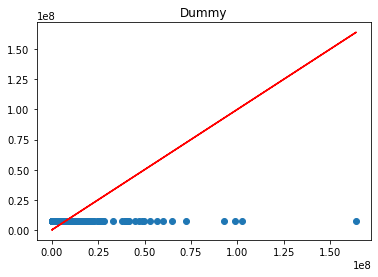

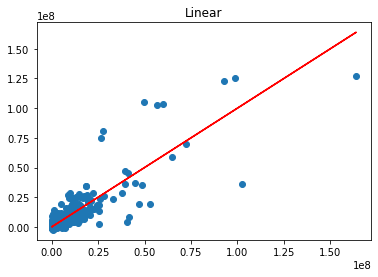

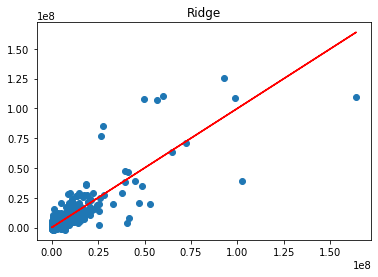

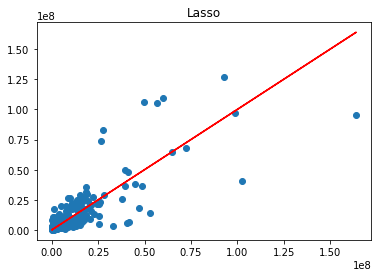

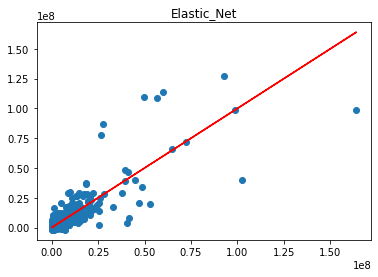

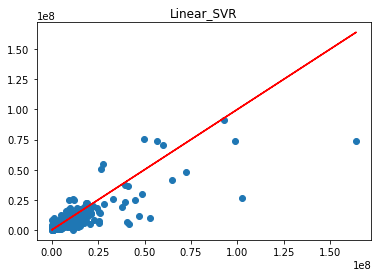

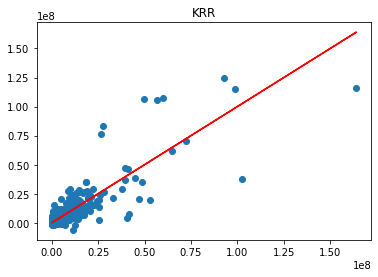

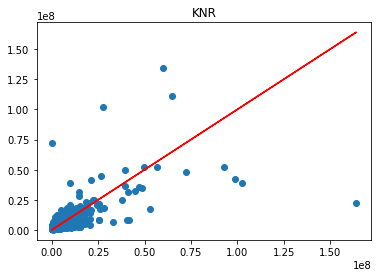

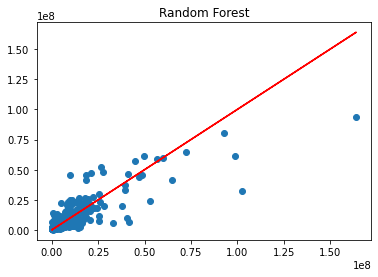

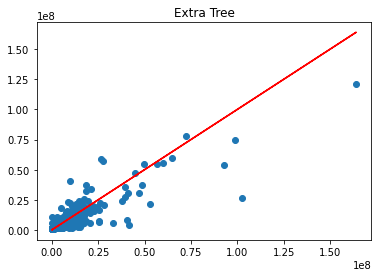

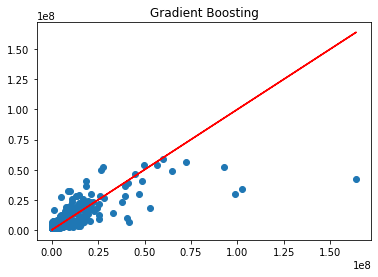

In [35]:
import warnings
warnings.filterwarnings("ignore")

# Les regressors sont testés 1 à 1 
df_Result = pd.DataFrame({})
for name_reg, reg in regressors_grid.items() : 
 
    model =  GridSearchCV(reg, grid_params[name_reg], cv=10) 
    
    start_time = timeit.default_timer()
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # calcul de l'erreur
    df_Result.loc[name_reg,'R2_train'] = round(metrics.r2_score(y_train, y_pred_train),2) # coéfficient de détermination
    df_Result.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
    
    df_Result.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    df_Result.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    
    df_Result.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
    df_Result.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)
 
    df_Result.loc[name_reg, 'run_time (s)'] = round(timeit.default_timer() - start_time,2)
    df_Result.loc[name_reg, 'best_params'] = str(model.best_params_)
    df_Result.loc[name_reg,'Model_dic'] = model
    
    print(name_reg, str(model.best_params_) )
    plt.figure()
    plt.scatter(y_test, y_pred_test)
    plt.plot(y_test, y_test , 'r-')
    plt.title(name_reg) 

df_Result.iloc[:,:-2]

In [36]:
df_Result.iloc[:,:-1]

,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s),best_params
Dummy,0.00,-0.00,2.037876e+07,1.442503e+07,8.335603e+06,7.735421e+06,0.02,{}
Linear,0.64,0.65,1.218423e+07,8.531674e+06,4.306122e+06,4.155076e+06,0.05,{}
Ridge,0.64,0.62,1.227807e+07,8.903831e+06,4.374486e+06,4.206827e+06,0.43,{'alpha': 1.6681005372000592}
Lasso,0.61,0.61,1.269657e+07,9.058292e+06,4.422532e+06,4.153539e+06,0.68,{'alpha': 215443.46900318822}
Elastic_Net,0.63,0.59,1.242873e+07,9.220914e+06,4.430046e+06,4.251423e+06,1.77,{'alpha': 0.005994842503189421}
Linear_SVR,0.55,0.67,1.373892e+07,8.281911e+06,3.572749e+06,3.418771e+06,11.56,"{'C': 59948425.03189421, 'epsilon': 46.4158883..."
KRR,0.64,0.63,1.222452e+07,8.811158e+06,4.352169e+06,4.236737e+06,2.28,{'gamma': 1e-20}
KNR,0.56,0.36,1.359422e+07,1.157964e+07,3.825163e+06,4.197080e+06,0.23,{'n_neighbors': 8}
Random Forest,0.96,0.71,3.823459e+06,7.756818e+06,1.408085e+06,3.541702e+06,47.87,"{'max_depth': 20, 'n_estimators': 100}"
Extra Tree,0.94,0.74,4.809168e+06,7.342922e+06,2.016432e+06,3.338891e+06,477.13,"{'criterion': 'mae', 'max_depth': 8, 'n_estima..."


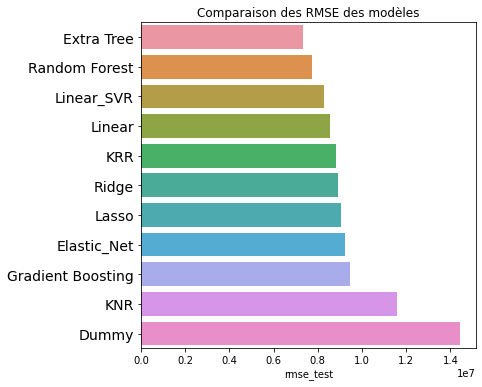

In [64]:
df_rmse_sort = pd.DataFrame(df_Result['rmse_test'].sort_values())
plt.figure(figsize=(6,6))
plt.title('Comparaison des RMSE des modèles')
ax = sns.barplot(y = df_rmse_sort.index , x = df_rmse_sort['rmse_test'])
ax.set_yticklabels(labels = df_rmse_sort.index, rotation=0, horizontalalignment='right',size=14)
plt.show()

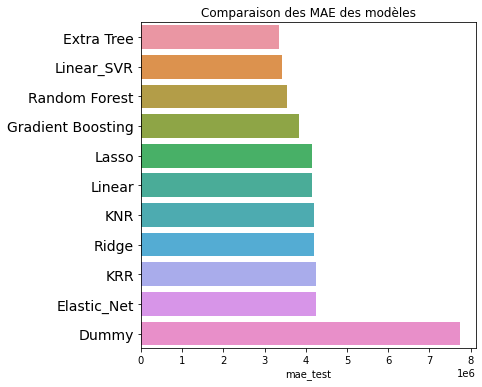

In [63]:
df_mae_sort = pd.DataFrame(df_Result['mae_test'].sort_values())
plt.figure(figsize=(6,6))
plt.title('Comparaison des MAE des modèles')
ax = sns.barplot(y = df_mae_sort.index , x = df_mae_sort['mae_test'])
ax.set_yticklabels(labels = df_mae_sort.index, rotation=0, horizontalalignment='right',size=14)
plt.show()

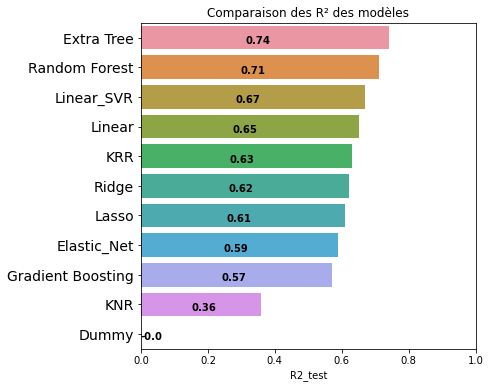

In [78]:
df_R2_sort = pd.DataFrame(df_Result['R2_test'].sort_values(ascending=False))
plt.figure(figsize=(6,6))
plt.title('Comparaison des R² des modèles')
ax = sns.barplot(y = df_R2_sort.index , x = df_R2_sort['R2_test'])
ax.set_yticklabels(labels = df_R2_sort.index, rotation=0, horizontalalignment='right',size=14)

for line in range(0,df_R2_sort.shape[0]):
     plt.text(df_R2_sort.R2_test[line]*0.42 , 0.2+line, df_R2_sort.R2_test[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.set_xbound(0, 1)
plt.show()

Les meilleurs résultats en terme de R², RMSE et MAE sont obtenus avec l'algorithme ensembliste **ExtraTrees** avec les hyperparamètres suivants: {'criterion': 'mae', 'max_depth': 8, 'n_estimators': 100}. 

**Etude du temps d'exécution de chaque algorithme**

In [91]:
grid_params_best = { 'Dummy'        : {},
                'Linear'       : {},
                'Ridge'        : {'alpha':[1.6681005372000592]},#Ridge__alpha
                'Lasso'        : {'alpha':[215443.46900318822]},
                'Elastic_Net'  : {'alpha': [0.005994842503189421]},
                'Linear_SVR'   : {'epsilon' :[46.41588833612782], 
                                 'C' : [59948425.03189421]},
                 'KRR'          : {'gamma' : [1e-20] },
                 'KNR'          : {'n_neighbors': [8]},
                 'Random Forest': {'max_depth': [20],
                                  'n_estimators': [100]},
                 'Extra Tree'    : {'n_estimators': [100],
                                  'criterion': ['mae'],
                                   'max_depth': [8]},# 
               'Gradient Boosting': {'n_estimators':[50]},
              } 

Dummy {}
Linear {}
Ridge {'alpha': 1.6681005372000592}
Lasso {'alpha': 215443.46900318822}
Elastic_Net {'alpha': 0.005994842503189421}
Linear_SVR {'C': 59948425.03189421, 'epsilon': 46.41588833612782}
KRR {'gamma': 1e-20}
KNR {'n_neighbors': 8}
Random Forest {'max_depth': 20, 'n_estimators': 100}
Extra Tree {'criterion': 'mae', 'max_depth': 8, 'n_estimators': 100}
Gradient Boosting {'n_estimators': 50}


,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s)
Dummy,0.00,-0.00,2.037876e+07,1.442503e+07,8.335603e+06,7.735421e+06,0.02
Linear,0.64,0.65,1.218423e+07,8.531674e+06,4.306122e+06,4.155076e+06,0.04
Ridge,0.64,0.62,1.227807e+07,8.903831e+06,4.374486e+06,4.206827e+06,0.20
Lasso,0.61,0.61,1.269657e+07,9.058292e+06,4.422532e+06,4.153539e+06,0.15
Elastic_Net,0.63,0.59,1.242873e+07,9.220914e+06,4.430046e+06,4.251423e+06,0.10
Linear_SVR,0.54,0.67,1.384515e+07,8.308814e+06,3.577240e+06,3.387368e+06,0.53
KRR,0.64,0.63,1.222452e+07,8.811158e+06,4.352169e+06,4.236737e+06,0.70
KNR,0.56,0.36,1.359422e+07,1.157964e+07,3.825163e+06,4.197080e+06,0.20
Random Forest,0.95,0.71,4.617360e+06,7.745482e+06,1.450336e+06,3.632873e+06,4.09
Extra Tree,0.94,0.76,5.036292e+06,7.132524e+06,2.034614e+06,3.315492e+06,50.09


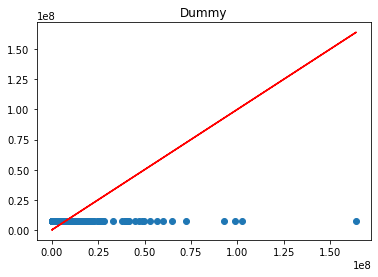

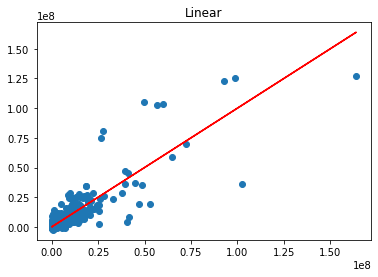

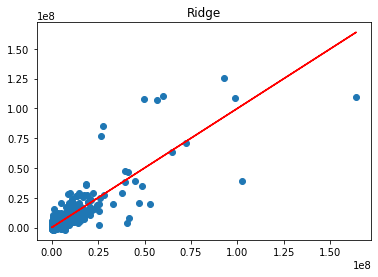

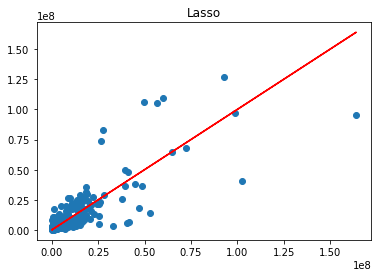

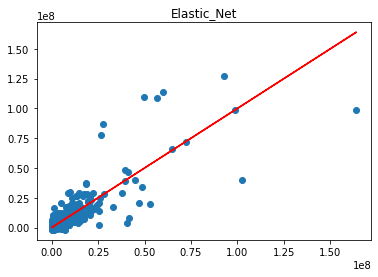

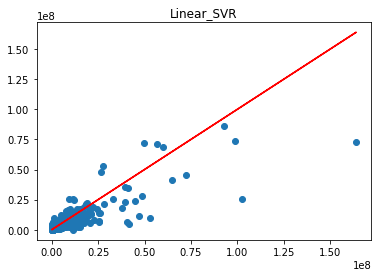

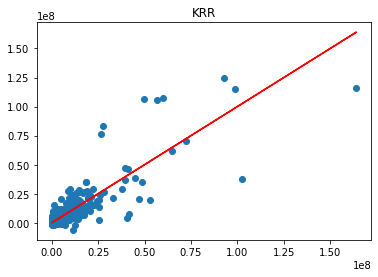

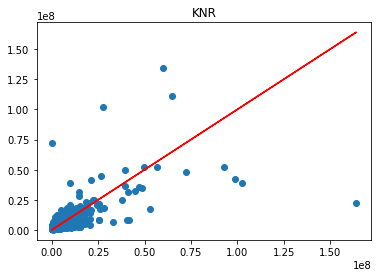

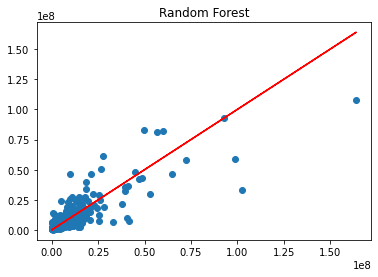

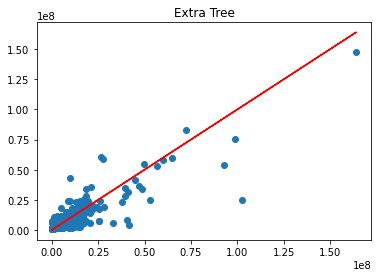

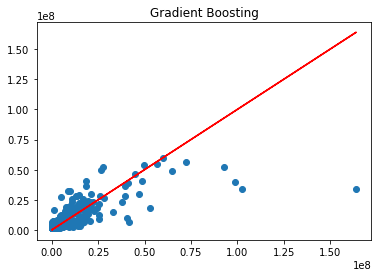

In [92]:
import warnings
warnings.filterwarnings("ignore")

# Les regressors sont testés 1 à 1 
df_Result_best = pd.DataFrame({})
for name_reg, reg in regressors_grid.items() : 
 
    model =  GridSearchCV(reg, grid_params_best[name_reg], cv=10) 
    
    start_time = timeit.default_timer()
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # calcul de l'erreur
    df_Result_best.loc[name_reg,'R2_train'] = round(metrics.r2_score(y_train, y_pred_train),2) # coéfficient de détermination
    df_Result_best.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
    
    df_Result_best.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    df_Result_best.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    
    df_Result_best.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
    df_Result_best.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)
 
    df_Result_best.loc[name_reg, 'run_time (s)'] = round(timeit.default_timer() - start_time,2)
    df_Result_best.loc[name_reg, 'best_params'] = str(model.best_params_)
    df_Result_best.loc[name_reg,'Model_dic'] = model
    
    print(name_reg, str(model.best_params_) )
    plt.figure()
    plt.scatter(y_test, y_pred_test)
    plt.plot(y_test, y_test , 'r-')
    plt.title(name_reg) 

df_Result_best.iloc[:,:-2]

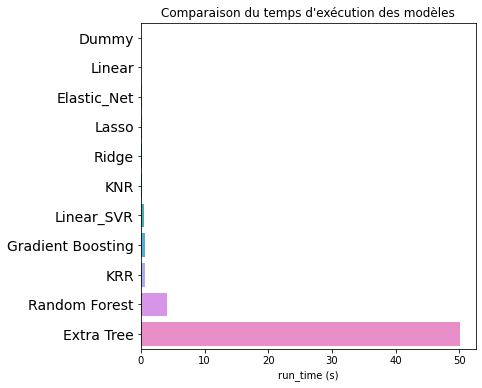

In [94]:
df_time_sort = pd.DataFrame(df_Result_best['run_time (s)'].sort_values())
plt.figure(figsize=(6,6))
plt.title("Comparaison du temps d'exécution des modèles")
ax = sns.barplot(y = df_time_sort.index , x = df_time_sort['run_time (s)'])
ax.set_yticklabels(labels = df_time_sort.index, rotation=0, horizontalalignment='right',size=14)
plt.show()

 L'ExtraTrees est l'algorithme qui prend plus de temps d'exécution par rapport aux autres algorithmes vu que c'est un algorithme ensembliste.  

### Avec 3 variables uniquement 

Dummy {}
Linear {}
Ridge {'alpha': 4.6415888336127775}
Lasso {'alpha': 215443.46900318822}
Elastic_Net {'alpha': 0.005994842503189421}
Linear_SVR {'C': 59948425.03189421, 'epsilon': 1e-05}
KRR {'gamma': 1e-20}
KNR {'n_neighbors': 8}
Random Forest {'max_depth': 5, 'n_estimators': 150}
Extra Tree {'criterion': 'mae', 'max_depth': 8, 'n_estimators': 50}
Gradient Boosting {'n_estimators': 50}


,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s),best_params
Dummy,0.00,-0.00,2.037876e+07,1.442503e+07,8.335603e+06,7.735421e+06,0.01,{}
Linear,0.62,0.68,1.263157e+07,8.148390e+06,4.258742e+06,4.064209e+06,0.02,{}
Ridge,0.59,0.61,1.307921e+07,9.061909e+06,4.409235e+06,4.254973e+06,0.15,{'alpha': 4.6415888336127775}
Lasso,0.59,0.63,1.299040e+07,8.794909e+06,4.467966e+06,4.245061e+06,0.14,{'alpha': 215443.46900318822}
Elastic_Net,0.60,0.63,1.290601e+07,8.788822e+06,4.372117e+06,4.184126e+06,0.15,{'alpha': 0.005994842503189421}
Linear_SVR,0.54,0.66,1.388645e+07,8.466732e+06,3.895447e+06,3.621806e+06,6.00,"{'C': 59948425.03189421, 'epsilon': 1e-05}"
KRR,0.50,0.49,1.442389e+07,1.032548e+07,8.312189e+06,7.667614e+06,2.13,{'gamma': 1e-20}
KNR,0.50,0.39,1.438818e+07,1.126945e+07,4.270550e+06,5.036061e+06,0.08,{'n_neighbors': 8}
Random Forest,0.87,0.59,7.344025e+06,9.234855e+06,3.377526e+06,4.178222e+06,24.39,"{'max_depth': 5, 'n_estimators': 150}"
Extra Tree,0.77,0.61,9.674118e+06,9.008724e+06,2.901649e+06,3.698291e+06,90.23,"{'criterion': 'mae', 'max_depth': 8, 'n_estima..."


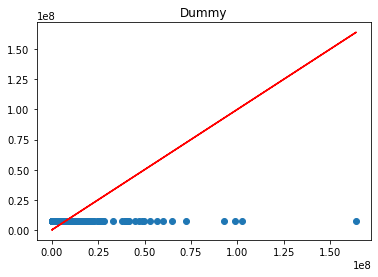

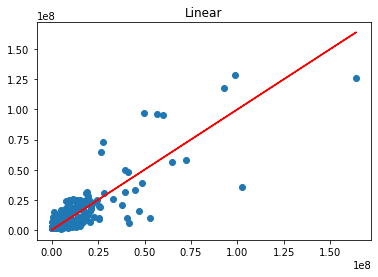

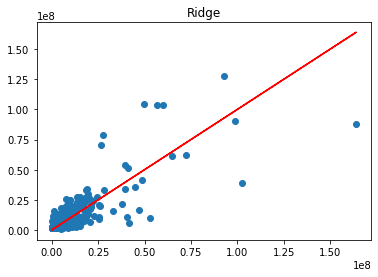

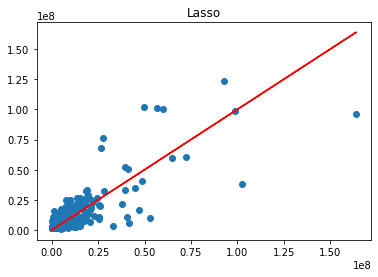

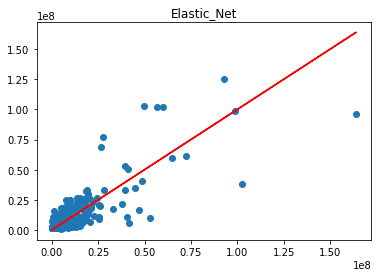

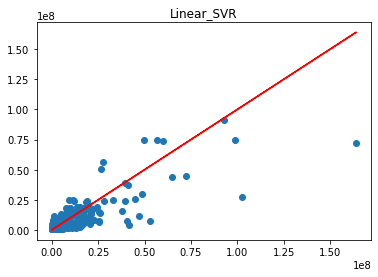

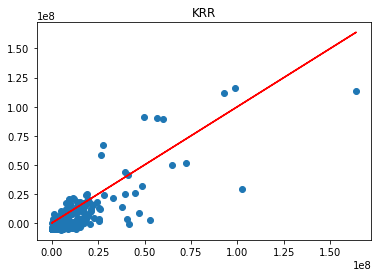

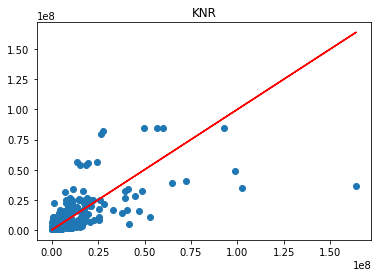

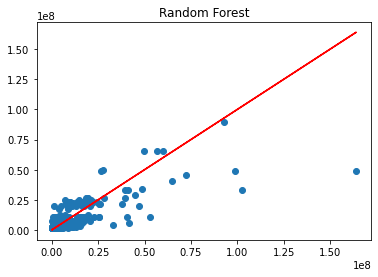

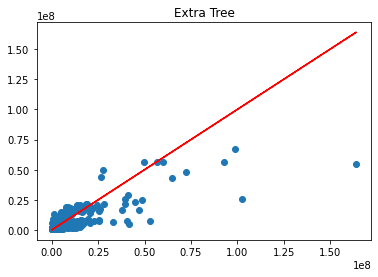

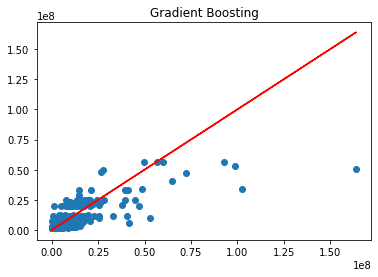

In [37]:
warnings.filterwarnings("ignore")

# Les regressors sont testés 1 à 1 
df_Result_rfe = pd.DataFrame({})
for name_reg, reg in regressors_grid.items() : 
 
    model_rfe =  GridSearchCV(reg, grid_params[name_reg], cv=10) 
    
    start_time = timeit.default_timer()
    model_rfe.fit(X_train_rfe, y_train)

    y_pred_test = model_rfe.predict(X_test_rfe)
    y_pred_train = model_rfe.predict(X_train_rfe)

    # calcul de l'erreur
    df_Result_rfe.loc[name_reg,'R2_train'] = round(metrics.r2_score(y_train, y_pred_train),2)
    df_Result_rfe.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
    
    df_Result_rfe.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    df_Result_rfe.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    
    df_Result_rfe.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
    df_Result_rfe.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)
    
    df_Result_rfe.loc[name_reg, 'run_time (s)'] = round(timeit.default_timer() - start_time,2)
    df_Result_rfe.loc[name_reg, 'best_params'] = str(model_rfe.best_params_)
    
    df_Result_rfe.loc[name_reg,'Model_dic'] = model_rfe
    
    print(name_reg, str(model_rfe.best_params_) )
    plt.figure()
    plt.scatter(y_test, y_pred_test)
    plt.plot(y_test, y_test , 'r-')
    plt.title(name_reg) 

df_Result_rfe.iloc[:,:-1]

On gagne en temps d'exécution, mais les résultats de prédiction baissent légèrement.  

### Avec TransformedTargetRegressor

Concernant nos variables à prédire, nous allons regarder l'impact du passage à l'échelle logarithmique sur les prédictions :

In [38]:
grid_params_log = { 'Dummy'        : {},
                'Linear'       : {},
                'Ridge'        : {'regressor__alpha':np.logspace(0, 4, 10)},#Ridge__alpha
                'Lasso'        : {'regressor__alpha':np.logspace(0, 10, 10)},
                'Elastic_Net'  : {'regressor__alpha': np.logspace(-10, 10, 10)},
                'Linear_SVR'   : {'regressor__epsilon' : np.logspace(-10, 10, 10), 
                                 'regressor__C' : np.logspace(-10, 10, 10)},
                 'KNR'          : {'regressor__n_neighbors': np.arange(2, 10, 2)},
                 'KRR'          : {'regressor__gamma' : np.logspace(-10, 0, 10) },
                'Random Forest': {'regressor__max_depth': [10, 20, 30],
                                  'regressor__n_estimators': [10, 100, 150]},
               'Extra Tree'    : {'regressor__n_estimators': [10,50,100],
                                   'regressor__max_depth': [2,8,16]},
               'Gradient Boosting': {'regressor__n_estimators':[10,50,100], 
                                    'regressor__learning_rate': np.logspace(-5, 0, 10),
                                    'regressor__max_depth':[10, 20, 30] },
                        'XGBR': {'regressor__n_estimators':[10,50,100,500, 1000] }
              } 

Dummy {}
Linear {}
Ridge {'regressor__alpha': 1291.5496650148827}
Lasso {'regressor__alpha': 1.0}
Elastic_Net {'regressor__alpha': 12.915496650148826}
Linear_SVR {'regressor__C': 0.07742636826811278, 'regressor__epsilon': 12.915496650148826}
KRR {'regressor__gamma': 1e-10}
KNR {'regressor__n_neighbors': 2}
Random Forest {'regressor__max_depth': 10, 'regressor__n_estimators': 10}
Extra Tree {'regressor__max_depth': 16, 'regressor__n_estimators': 50}
Gradient Boosting {'regressor__learning_rate': 0.07742636826811278, 'regressor__max_depth': 10, 'regressor__n_estimators': 50}


,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test,run_time (s),best_params,Model_dic
Dummy,-0.06,-0.10,2.093597e+07,1.510756e+07,6.529270e+06,6.270139e+06,0.03,{},"GridSearchCV(cv=10,\n estimator=Tr..."
Linear,-21.65,-90.25,9.698625e+07,1.377665e+08,8.832226e+06,1.529209e+07,0.06,{},"GridSearchCV(cv=10,\n estimator=Tr..."
Ridge,0.13,-2.15,1.898271e+07,2.561287e+07,5.584762e+06,6.424847e+06,0.56,{'regressor__alpha': 1291.5496650148827},"GridSearchCV(cv=10,\n estimator=Tr..."
Lasso,-0.06,-0.10,2.093597e+07,1.510756e+07,6.529270e+06,6.270139e+06,0.53,{'regressor__alpha': 1.0},"GridSearchCV(cv=10,\n estimator=Tr..."
Elastic_Net,-0.06,-0.10,2.093597e+07,1.510756e+07,6.529270e+06,6.270139e+06,1.21,{'regressor__alpha': 12.915496650148826},"GridSearchCV(cv=10,\n estimator=Tr..."
Linear_SVR,-0.15,-0.27,2.182708e+07,1.625451e+07,7.820934e+06,7.520437e+06,10.54,"{'regressor__C': 0.07742636826811278, 'regress...","GridSearchCV(cv=10,\n estimator=Tr..."
KRR,-16.88,-103.07,8.617627e+07,1.471251e+08,8.579512e+06,1.616916e+07,2.38,{'regressor__gamma': 1e-10},"GridSearchCV(cv=10,\n estimator=Tr..."
KNR,0.73,0.40,1.056736e+07,1.120368e+07,2.510954e+06,3.993117e+06,0.26,{'regressor__n_neighbors': 2},"GridSearchCV(cv=10,\n estimator=Tr..."
Random Forest,0.86,0.52,7.582567e+06,9.950270e+06,2.202979e+06,3.873786e+06,22.21,"{'regressor__max_depth': 10, 'regressor__n_est...","GridSearchCV(cv=10,\n estimator=Tr..."
Extra Tree,0.99,0.61,1.759685e+06,9.014133e+06,6.660938e+05,3.517857e+06,7.40,"{'regressor__max_depth': 16, 'regressor__n_est...","GridSearchCV(cv=10,\n estimator=Tr..."


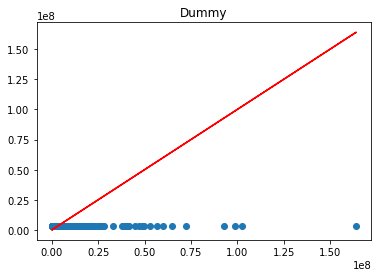

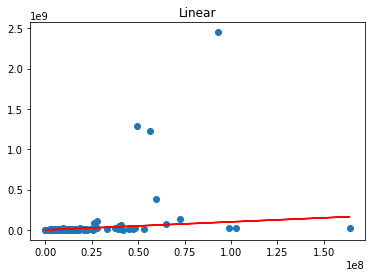

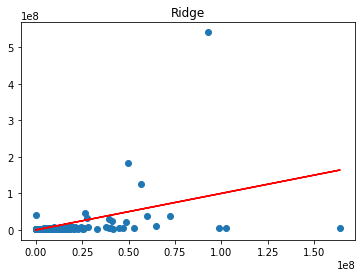

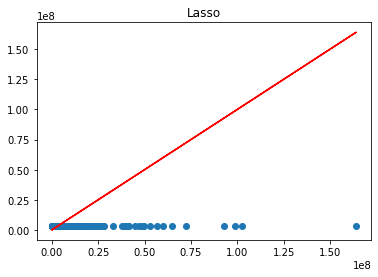

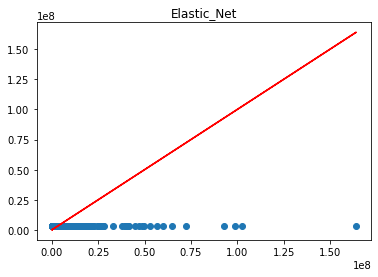

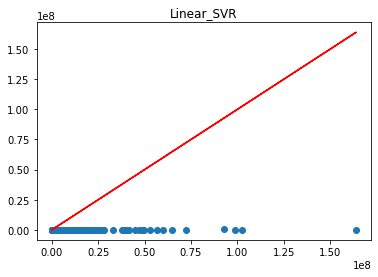

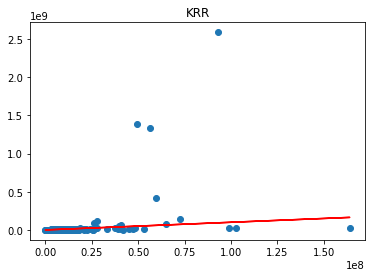

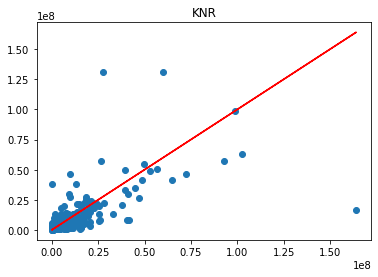

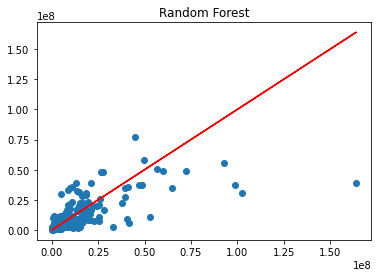

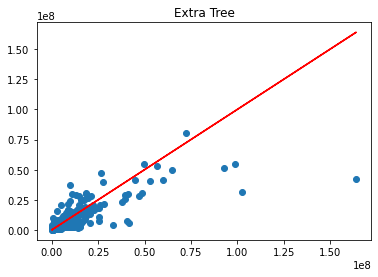

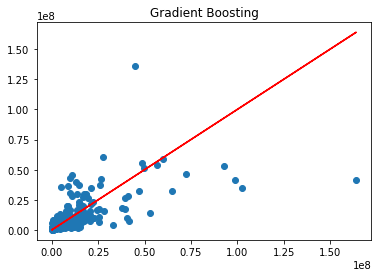

In [39]:
# Les regressors sont testés 1 à 1 
df_Result_log = pd.DataFrame({})
for name_reg, reg in regressors_grid.items() : 
    
    model =  GridSearchCV(TransformedTargetRegressor(regressor=reg, func=np.log, inverse_func=np.exp), grid_params_log[name_reg], cv=10) 
    
    start_time = timeit.default_timer() 
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # calcul de l'erreur
    df_Result_log.loc[name_reg,'R2_train'] = round(metrics.r2_score(y_train, y_pred_train),2) # coéfficient de détermination
    df_Result_log.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)
    
    df_Result_log.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    df_Result_log.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    
    df_Result_log.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
    df_Result_log.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)
    
    df_Result_log.loc[name_reg, 'run_time (s)'] = round(timeit.default_timer() - start_time,2)
    df_Result_log.loc[name_reg, 'best_params'] = str(model.best_params_)
    
    df_Result_log.loc[name_reg,'Model_dic'] = model
    
    print(name_reg, str(model.best_params_) )
    plt.figure()
    plt.scatter(y_test, y_pred_test)
    plt.plot(y_test, y_test , 'r-')
    plt.title(name_reg) 

df_Result_log

Le passage au log de notre variable target n'a pas amélioré les résultats de la prédiction au contraire ces dernières ont chuté très significativement.  

# Modèle final choisi

Modèle final choisi pour la prédiction de l'énergie: **ExtraTreesRegressor(criterion= 'mae', max_depth= 8, n_estimators= 100)** .    

L'ExtraTrees est l'algorithme qui donne les meilleurs performances en terme de R², RMSE et MAE. 
Le seul inconvénient est qu'il prend plus de temps d'exécution par rapport aux autres algorithmes puisqu'il est ensembliste.


In [80]:
# Create final model
name_reg = 'Extra Tree'
model_final = ExtraTreesRegressor(criterion= 'mae', max_depth= 8, n_estimators= 100)

# Fit model
model_final.fit(X_train, y_train)

# Prediction
y_pred_test = model_final.predict(X_test)
y_pred_train = model_final.predict(X_train)

# Evaluate
dff_Result = pd.DataFrame({})
dff_Result.loc[name_reg,'R2_train'] = round(metrics.r2_score(y_train, y_pred_train),2) # coéfficient de détermination
dff_Result.loc[name_reg,'R2_test'] = round(metrics.r2_score(y_test, y_pred_test),2)

dff_Result.loc[name_reg, 'rmse_train'] = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
dff_Result.loc[name_reg, 'rmse_test'] = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))

dff_Result.loc[name_reg, 'mae_train'] = metrics.mean_absolute_error(y_train, y_pred_train)
dff_Result.loc[name_reg, 'mae_test'] = metrics.mean_absolute_error(y_test, y_pred_test)

dff_Result

,R2_train,R2_test,rmse_train,rmse_test,mae_train,mae_test
Extra Tree,0.95,0.75,4.683594e+06,7.189772e+06,2.011805e+06,3.273854e+06


**Etude de l'importance des variables dans la prédiction**

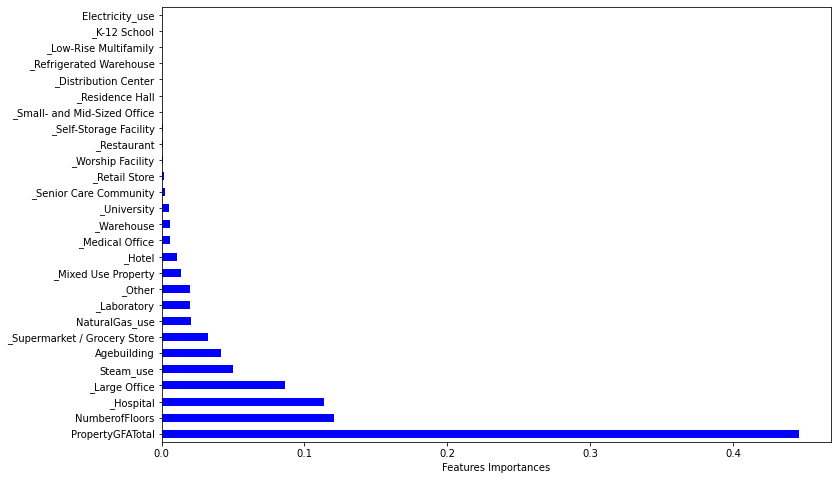

In [79]:
features_importances = pd.Series(model_final.feature_importances_, index=X_train.columns)
plt.figure(figsize=(12,8))
features_importances.nlargest(30).plot(kind='barh', color='b')

plt.xlabel('Features Importances')
plt.show()

In [84]:
features_importances.sort_values(ascending=False)

PropertyGFATotal                0.446332
NumberofFloors                  0.120994
_Hospital                       0.113537
_Large Office                   0.086144
Steam_use                       0.049775
Agebuilding                     0.041558
_Supermarket / Grocery Store    0.032232
NaturalGas_use                  0.020574
_Laboratory                     0.020159
_Other                          0.019741
_Mixed Use Property             0.013376
_Hotel                          0.010520
_Medical Office                 0.006115
_Warehouse                      0.005876
_University                     0.005062
_Senior Care Community          0.002571
_Retail Store                   0.001608
_Worship Facility               0.001155
_Restaurant                     0.000909
_Self-Storage Facility          0.000724
_Small- and Mid-Sized Office    0.000593
_Residence Hall                 0.000174
_Distribution Center            0.000156
_Refrigerated Warehouse         0.000114
_Low-Rise Multif

Les variables les plus importantes pour notre modèle de prédiction de l'énergie sont: 
* la surface
* le nombre d'étage 
* les catégories Hôpital, Grand-bureau
* utilisation de la vapeur comme énergie
* l'âge du bâtiment 


In [95]:
# plt.figure(figsize=(12,8))
# plt.scatter(y_test, y_pred_test)
# plt.plot(y_test, y_test , 'r-')
# plt.title('Valeurs prédites VS valeurs réelles | Variable SiteEnergyUse(kBtu)') 
# plt.xlabel('Valeurs réelles de test')
# plt.ylabel('Valeurs prédites')